<a href="https://colab.research.google.com/github/JvitorS23/notebooks-PIBIC/blob/master/knowledge-distiller-pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#libera memória GPU
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat May 30 13:47:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    76W / 149W |    332MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Imports

In [ ]:
from collections import OrderedDict
import os
from skimage.util import random_noise
import numpy as np
from tqdm import tqdm
from random import shuffle
import torch.nn.functional as F
import torch
import random
import time
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torchvision
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
import math
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, RandomSampler
import torch.nn as nn
from torchvision import transforms, datasets, models
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from random import randint
from __future__ import print_function
from __future__ import division
import copy
import csv
import sklearn
import matplotlib as mpl
RS = 23

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

# Preparação dos dados

O dataset deve estar em formato zip no google drive

In [ ]:
# monta o google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/My\ Drive/chest_xray.zip

In [ ]:
!rm -rf /content/chest_xray-bal

# Funções

In [ ]:
def prepararDados(input_size):
  datadir = '/content/chest_xray'
  traindir = datadir + '/train/'
  validdir = datadir + '/val/'
  testdir = datadir + '/test/'
 
  batch_size = 32

  image_transforms = {
    'train': transforms.Compose([    
        transforms.Resize((input_size,input_size)),        
        transforms.RandomHorizontalFlip(), 
        transforms.RandomResizedCrop((input_size,input_size)),       
        transforms.ToTensor(), 
      ]),

    'test': transforms.Compose([
        transforms.Resize((input_size,input_size)),      
        transforms.ToTensor(),
            ]),

    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),       
        transforms.ToTensor(),
            ])
  }
  
  # Datasets
  data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
  } 


  dataloaders = {
      'train': DataLoader(data['train'], shuffle=True, batch_size=batch_size, num_workers=0),
      'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
      'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
  }
  return dataloaders

def create_tensor(shape = [2,2,2]):
    ndim = len(shape)
    view_shape = [1,] * ndim
    res = 0.
    for d in range(ndim):
        dim_size = shape[d]
        t = torch.arange(dim_size)
        view_shape[d] = dim_size
        t = t.view(*view_shape).expand(*shape)
        view_shape[d] = 1
        res += t

    return res

def testeDoModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
  model.eval()
  running_loss = 0.0
  running_correct = 0
  tot_predictions = []
  labels = []
  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    
    output = model(data)
    loss = F.cross_entropy(output,target)
    running_loss += loss.item()
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()
    
    tot_predictions.extend(preds.data.cpu().numpy())
    labels.extend(target.data.cpu().numpy())
  loss = running_loss/len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)
  print(f'Loss is {loss:{5}.{2}} Accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{6}.{4}}%\n')
  return tot_predictions, labels


def testeAgrupamento(resnet, vgg, densenet, alexnet, googlenet, data_loader):
  if (torch.cuda.is_available()):
    resnet = resnet.cuda()
    vgg = vgg.cuda()
    densenet = densenet.cuda()
    alexnet = alexnet.cuda()
    googlenet = googlenet.cuda()
  
  resnet.eval()
  densenet.eval()
  vgg.eval()
  alexnet.eval()
  googlenet.eval()

  running_loss = 0.0
  running_corrects = 0
  tot_predictions = []
  labels = []
  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    
    output_resnet = resnet(data)
    output_densenet = densenet(data)
    output_alexnet = alexnet(data)
    output_googlenet = googlenet(data)
    output_vgg = vgg(data)
    
    # #resize for inception    
    # data = data.cpu()   
    # data_resized = create_tensor(shape=[len(data), 3, 299, 299])
    # for i in range(len(data)):      
    #   img_PIL = transforms.ToPILImage()(data[i])
    #   img_PIL = torchvision.transforms.Resize([299,299])(img_PIL)
    #   data_resized[i] = torchvision.transforms.ToTensor()(img_PIL) 

    # data_resized = data_resized.cuda()
    # output_inception = inception(data_resized)

    preds_resnet = output_resnet.data.max(dim=1,keepdim=True)[1]
    preds_densenet = output_densenet.data.max(dim=1,keepdim=True)[1]
    preds_vgg = output_vgg.data.max(dim=1,keepdim=True)[1]
    preds_googlenet = output_googlenet.data.max(dim=1,keepdim=True)[1]
    preds_alexnet = output_alexnet.data.max(dim=1,keepdim=True)[1]

    final_preds = []
    for i in range(len(preds_resnet)):
      item_pred = [preds_resnet[i].item(), preds_densenet[i].item(), preds_vgg[i].item(), preds_googlenet[i].item(), preds_alexnet[i].item()]
      soma = sum(item_pred)
      if soma >= 3:
        final_preds.append(1)
      else: 
        final_preds.append(0)

    for i in range(len(target)):
      if target[i] == final_preds[i]: 
        running_corrects += 1
    
    tot_predictions.extend(final_preds)
    labels.extend(target.data.cpu().numpy())
    

  accuracy = 100. * running_corrects/len(data_loader.dataset)
  print(f'Accuracy is {running_corrects}/{len(data_loader.dataset)}{accuracy:{6}.{4}}%\n')
  return tot_predictions, labels
  

def testeAgrupamentoMediaLogits(resnet, vgg, densenet, alexnet, googlenet, data_loader):
  if (torch.cuda.is_available()):
    resnet = resnet.cuda()
    vgg = vgg.cuda()
    densenet = densenet.cuda()
    alexnet = alexnet.cuda()
    googlenet = googlenet.cuda()
  
  resnet.eval()
  densenet.eval()
  vgg.eval()
  alexnet.eval()
  googlenet.eval()

  running_loss = 0.0
  running_corrects = 0
  tot_predictions = []
  labels = []
  for batch in data_loader:
    data , target = batch
    if torch.cuda.is_available():
      data,target = data.cuda(),target.cuda()
    
    output_resnet = resnet(data)
    output_densenet = densenet(data)
    output_alexnet = alexnet(data)
    output_googlenet = googlenet(data)
    output_vgg = vgg(data)

    outputs = (output_resnet+output_densenet+output_alexnet+output_googlenet+output_vgg)/5
      
    _, preds = torch.max(outputs, 1)
    

    for i in range(len(target)):
      if target[i] == preds[i]: 
        running_corrects += 1

    final_preds = []
    for i in range(len(preds)):
      final_preds.append(preds[i].item())
    
    tot_predictions.extend(final_preds)
    labels.extend(target.data.cpu().numpy())
  

  accuracy = 100. * running_corrects/len(data_loader.dataset)
  print(f'Accuracy is {running_corrects}/{len(data_loader.dataset)}{accuracy:{6}.{4}}%\n')
  return tot_predictions, labels


def metricasModelo(model, data_loader):
  if (torch.cuda.is_available()):
    model = model.cuda()
    
  print('========= Métricas do modelo ============\n')
  y_pred, y_test = testeDoModelo(model, data_loader)
  target_names = ['normal', 'pneumonia']
  print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
  print('\n========= Confusion Matrix ============\n')
  confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1])
  fig, ax = plt.subplots(figsize=(3,3))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.tight_layout()
  plt.savefig('confusion_matrix.png', dpi=300)
  plt.show()

def carregar_resnet():
  resnet, input_size = initialize_model('resnet', 2, True, use_pretrained=True)
  resnet.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/Resnet18/resnet.acc'))
  return resnet, input_size

def carregar_densenet():
  densenet, input_size = initialize_model('densenet', 2, True, use_pretrained=True)
  densenet.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/Densenet121/densenet.acc'))
  return densenet, input_size

def carregar_alexnet():
  alexnet, input_size = initialize_model('alexnet', 2, True, use_pretrained=True)
  alexnet.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/AlexNet/alexnet.acc'))
  return alexnet, input_size

def carregar_googlenet():
  googlenet, input_size = initialize_model('googlenet', 2, True, use_pretrained=True)
  googlenet.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/GoogLeNet/googlenet.acc'))
  return googlenet, input_size

def carregar_inception():
  inception, input_size = initialize_model('inception', 2, True, use_pretrained=True)
  inception.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/Inception V3/inception.acc'))
  return inception, input_size

def carregar_vgg():
  vgg = models.vgg19_bn(pretrained=True)
  num_ftrs = vgg.classifier[6].in_features
  vgg.classifier[6] = nn.Linear(num_ftrs, 2)
  vgg.load_state_dict(torch.load('/content/drive/My Drive/Modelos Salvos/VGG/vgg.acc'))
  return vgg, 224

def carregar_cnn(model_save_name):
    model = Network()    
    model.load_state_dict(torch.load(model_save_name))
    return model

def carregar_ensemble():
  #load the models
  resnet, input_size = carregar_resnet()
  vgg, input_size = carregar_vgg()
  densenet, input_size = carregar_densenet()
  alexnet, input_size = carregar_alexnet()
  googlenet, input_size = carregar_googlenet()
  ensemble = {'resnet': resnet, 'vgg': vgg, 'densenet': densenet, 'alexnet': alexnet, 'googlenet': googlenet}
  return ensemble

def salvar_modelo(model, model_save_name):
    torch.save(model.state_dict(), model_save_name)  

def plotar(train_loss, train_acc, val_loss, val_acc):
  plt.title('Accuracy over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(train_acc, label='train')
  plt.plot(val_acc, label='val')
  plt.grid(True, which='both', axis='both')  
  plt.tight_layout()
  plt.legend()
  plt.show()
  plt.title('Loss over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='val')
  plt.grid(True, which='both', axis='both')
  plt.tight_layout()
  plt.legend()
  plt.show()


def train_model(model, dataloaders, criterion, optimizer, save_name, num_epochs=25,  is_inception=False):
  since = time.time()
  
  # informações para plotagem
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]

  # Gerencia a Learning Rate
  scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
 

  for epoch in range(1, num_epochs+1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    epochStart = time.time()  

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
            
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
      epoch_loss = 0.0
      epoch_acc = 0.0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:

        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          # Special case for inception because in training it has an auxiliary output. In train
          #   mode we calculate the loss by summing the final output and the auxiliary output
          #   but in testing we only consider the final output.
          if is_inception and phase == 'train':
            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)      
      
      if phase == 'train':
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc.item())         
      else:
        val_losses.append(epoch_loss)
        val_accuracy.append(epoch_acc.item())    

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        salvar_modelo(model, '/content/drive/My Drive/Modelos Salvos/'+save_name+'.acc')
        print('Val acc up saving model')
      if phase == 'val':
        val_acc_history.append(epoch_acc)    
    scheduler.step()
    epochEnd = time.time()
    print('Duração:', (epochEnd - epochStart))
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  
  #plota os gráficos
  plotar(train_losses, train_accuracy, val_losses, val_accuracy)

  #salvar dados da plotagem
  train = {'loss': train_losses, 'acc': train_accuracy}
  valid = {'loss': val_losses, 'acc': val_accuracy}

  df = pd.DataFrame(data=train)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_train.csv')

  df = pd.DataFrame(data=valid)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_valid.csv')
  
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  # Initialize these variables which will be set in this if statement. Each of these
  
  #   variables is model specific.
  model_ft = None
  input_size = 0

  if model_name == "resnet":
    """ Resnet18
    """
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    set_parameter_requires_grad(model_ft.layer4, True)
    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == "alexnet":
    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft.features, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

  elif model_name == "vgg":
    """ VGG11_bn
    """
    model_ft = models.vgg19_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

  elif model_name == "squeezenet":
    """ Squeezenet
    """
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft.features, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224

  elif model_name == "densenet":
    """ Densenet
    """
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == "inception":
    """ Inception v3
    Be careful, expects (299,299) sized images and has auxiliary output
    """
    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299

  elif model_name == "googlenet":
    """ GoogLeNet
    """
    model_ft = models.googlenet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  else:
      print("Invalid model name, exiting...")
      exit()

  return model_ft, input_size




# Resnet


In [ ]:
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

for param in model_ft.layer4.parameters():
  param.requires_grad = True

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


Epoch 1/50
----------
train Loss: 0.3671 Acc: 0.8512
val Loss: 0.2906 Acc: 0.8814
Val acc up saving model
Duração: 122.86395835876465
Epoch 2/50
----------
train Loss: 0.2600 Acc: 0.8871
val Loss: 0.2119 Acc: 0.9103
Val acc up saving model
Duração: 122.85687637329102
Epoch 3/50
----------
train Loss: 0.2342 Acc: 0.9007
val Loss: 0.4842 Acc: 0.7917
Duração: 122.39977669715881
Epoch 4/50
----------
train Loss: 0.2119 Acc: 0.9139
val Loss: 0.4189 Acc: 0.8397
Duração: 122.22833371162415
Epoch 5/50
----------
train Loss: 0.2118 Acc: 0.9107
val Loss: 0.2070 Acc: 0.9247
Val acc up saving model
Duração: 122.7921872138977
Epoch 6/50
----------
train Loss: 0.2069 Acc: 0.9137
val Loss: 0.3671 Acc: 0.8542
Duração: 123.43908619880676
Epoch 7/50
----------
train Loss: 0.1987 Acc: 0.9153
val Loss: 0.2045 Acc: 0.9231
Duração: 124.00618052482605
Epoch 8/50
----------
train Loss: 0.1852 Acc: 0.9266
val Loss: 0.2398 Acc: 0.9071
Duração: 126.18647503852844
Epoch 9/50
----------
train Loss: 0.1864 Acc: 0.9

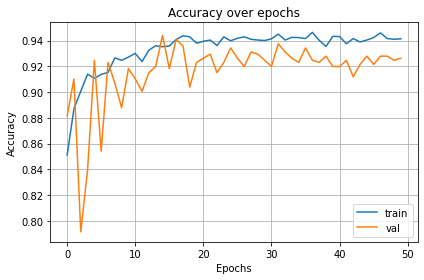

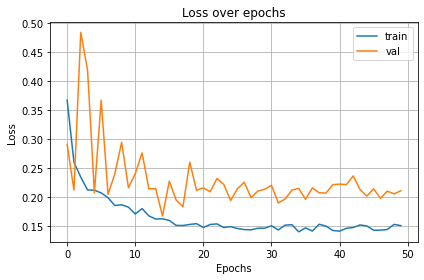

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Train set
========= Métricas do modelo ============

Loss is 0.0033 Accuracy is 4998/5216 95.82%

              precision    recall  f1-score   support

      normal      0.892     0.952     0.921      1341
   pneumonia      0.983     0.960     0.972      3875

    accuracy                          0.958      5216
   macro avg      0.938     0.956     0.946      5216
weighted avg      0.960     0.958     0.959      5216


========= Confusion Matrix ============



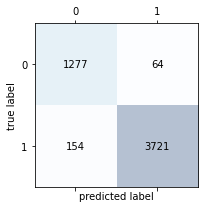

Test set
========= Métricas do modelo ============

Loss is 0.0052 Accuracy is 589/624 94.39%

              precision    recall  f1-score   support

      normal      0.959     0.889     0.922       234
   pneumonia      0.936     0.977     0.956       390

    accuracy                          0.944       624
   macro avg      0.947     0.933     0.939       624
weighted avg      0.945     0.944     0.943       624


========= Confusion Matrix ============



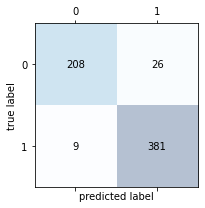

In [ ]:
resnet, input_size = carregar_resnet()
loaders = prepararDados(input_size)
print('Train set')
metricasModelo(resnet, loaders['train'])
print('Test set')
metricasModelo(resnet, loaders['test'])

# Inception V3

In [ ]:
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
for param in model_ft.Mixed_7c.parameters():
  param.requires_grad = True

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
inception, input_size = carregar_inception()
loaders = prepararDados(input_size)
print('Train set')
metricasModelo(inception, loaders['train'])
print('Test set')
metricasModelo(inception, loaders['test'])

# DenseNet


In [ ]:
model_name = "densenet"

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

for param in model_ft.features.denseblock4.denselayer15.parameters():
  param.requires_grad = True

for param in model_ft.features.denseblock4.denselayer16.parameters():
  param.requires_grad = True

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.denseblock4.denselayer15.norm1.weight
	 features.denseblock4.denselayer15.norm1.bias
	 features.denseblock4.denselayer15.conv1.weight
	 features.denseblock4.denselayer15.norm2.weight
	 features.denseblock4.denselayer15.norm2.bias
	 features.denseblock4.denselayer15.conv2.weight
	 features.denseblock4.denselayer16.norm1.weight
	 features.denseblock4.denselayer16.norm1.bias
	 features.denseblock4.denselayer16.conv1.weight
	 features.denseblock4.denselayer16.norm2.weight
	 features.denseblock4.denselayer16.norm2.bias
	 features.denseblock4.denselayer16.conv2.weight
	 classifier.weight
	 classifier.bias


Epoch 1/50
----------
train Loss: 0.3452 Acc: 0.8466
val Loss: 0.2615 Acc: 0.8814
Val acc up saving model
Duração: 182.4960436820984
Epoch 2/50
----------
train Loss: 0.2918 Acc: 0.8750
val Loss: 0.3888 Acc: 0.8317
Duração: 181.230131149292
Epoch 3/50
----------
train Loss: 0.2811 Acc: 0.8806
val Loss: 0.3493 Acc: 0.8894
Val acc up saving model
Duração: 181.86509156227112
Epoch 4/50
----------
train Loss: 0.2409 Acc: 0.8997
val Loss: 0.3106 Acc: 0.8942
Val acc up saving model
Duração: 182.9182767868042
Epoch 5/50
----------
train Loss: 0.2410 Acc: 0.8940
val Loss: 0.2730 Acc: 0.9054
Val acc up saving model
Duração: 183.37167954444885
Epoch 6/50
----------
train Loss: 0.2362 Acc: 0.9005
val Loss: 0.2706 Acc: 0.9087
Val acc up saving model
Duração: 183.9006929397583
Epoch 7/50
----------
train Loss: 0.2391 Acc: 0.9045
val Loss: 0.2731 Acc: 0.9071
Duração: 183.46179699897766
Epoch 8/50
----------
train Loss: 0.2260 Acc: 0.9049
val Loss: 0.2421 Acc: 0.9247
Val acc up saving model
Duração: 

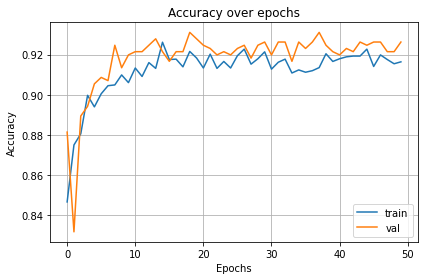

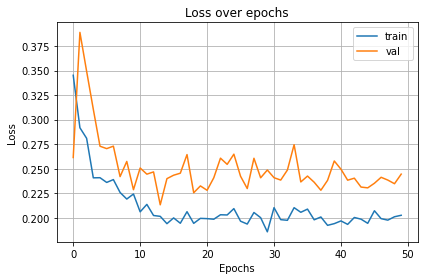

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



Train set
========= Métricas do modelo ============

Loss is 0.0041 Accuracy is 4956/5216 95.02%

              precision    recall  f1-score   support

      normal      0.874     0.942     0.907      1341
   pneumonia      0.979     0.953     0.966      3875

    accuracy                          0.950      5216
   macro avg      0.927     0.947     0.936      5216
weighted avg      0.952     0.950     0.951      5216


========= Confusion Matrix ============



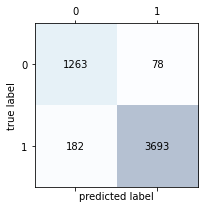

Test set
========= Métricas do modelo ============

Loss is 0.0071 Accuracy is 581/624 93.11%

              precision    recall  f1-score   support

      normal      0.953     0.859     0.903       234
   pneumonia      0.920     0.974     0.946       390

    accuracy                          0.931       624
   macro avg      0.936     0.917     0.925       624
weighted avg      0.932     0.931     0.930       624


========= Confusion Matrix ============



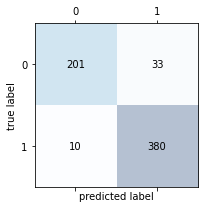

In [ ]:
densenet, input_size = carregar_densenet()
loaders = prepararDados(input_size)
print('Train set')
metricasModelo(densenet, loaders['train'])
print('Test set')
metricasModelo(densenet, loaders['test'])

# AlexNet

In [ ]:
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


Epoch 1/50
----------
Epoch 1/50
----------
train Loss: 0.4833 Acc: 0.7970
train Loss: 0.4833 Acc: 0.7970
val Loss: 0.3269 Acc: 0.8638
val Loss: 0.3269 Acc: 0.8638
Val acc up saving model
Duração: 122.00450682640076
Epoch 2/50
----------
Val acc up saving model
Duração: 122.00450682640076
Epoch 2/50
----------
train Loss: 0.3798 Acc: 0.8257
train Loss: 0.3798 Acc: 0.8257
val Loss: 0.3408 Acc: 0.9006
val Loss: 0.3408 Acc: 0.9006
Val acc up saving model
Duração: 121.24214100837708
Epoch 3/50
----------
Val acc up saving model
Duração: 121.24214100837708
Epoch 3/50
----------
train Loss: 0.3669 Acc: 0.8436
train Loss: 0.3669 Acc: 0.8436
val Loss: 0.3421 Acc: 0.8718
Duração: 120.97705340385437
Epoch 4/50
----------
val Loss: 0.3421 Acc: 0.8718
Duração: 120.97705340385437
Epoch 4/50
----------
train Loss: 0.3465 Acc: 0.8507
train Loss: 0.3465 Acc: 0.8507
val Loss: 0.3670 Acc: 0.8862
Duração: 120.84608459472656
Epoch 5/50
----------
val Loss: 0.3670 Acc: 0.8862
Duração: 120.84608459472656
Ep

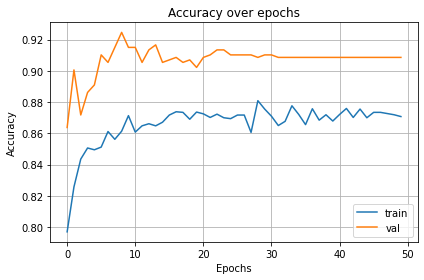

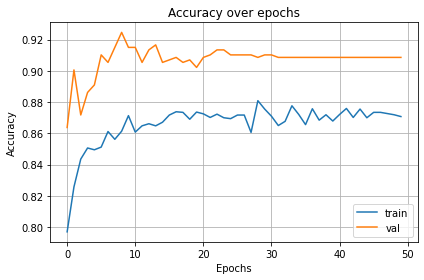

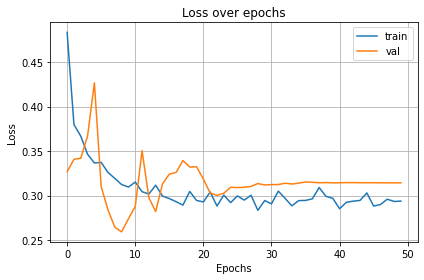

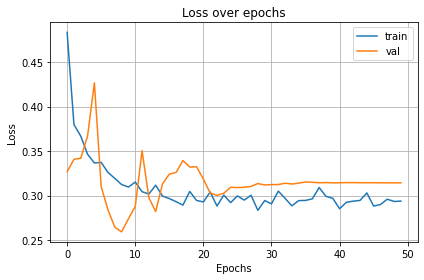

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Train set
========= Métricas do modelo ============

Loss is 0.0074 Accuracy is 4732/5216 90.72%

              precision    recall  f1-score   support

      normal      0.805     0.843     0.824      1341
   pneumonia      0.945     0.929     0.937      3875

    accuracy                          0.907      5216
   macro avg      0.875     0.886     0.880      5216
weighted avg      0.909     0.907     0.908      5216


========= Confusion Matrix ============



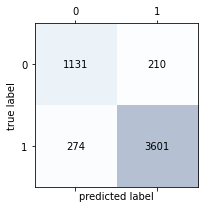

Test set
========= Métricas do modelo ============

Loss is 0.0086 Accuracy is 577/624 92.47%

              precision    recall  f1-score   support

      normal      0.923     0.872     0.897       234
   pneumonia      0.926     0.956     0.941       390

    accuracy                          0.925       624
   macro avg      0.924     0.914     0.919       624
weighted avg      0.925     0.925     0.924       624


========= Confusion Matrix ============



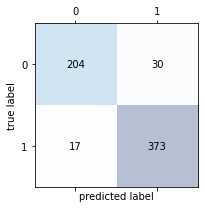

In [ ]:
alexnet, input_size = carregar_alexnet()
loaders = prepararDados(input_size)
print('Train set')
metricasModelo(alexnet, loaders['train'])
print('Test set')
metricasModelo(alexnet, loaders['test'])

# GoogLeNet

In [ ]:
model_name = "googlenet"

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft = models.googlenet(pretrained=feature_extract)
set_parameter_requires_grad(model_ft, feature_extract)
for param in model_ft.inception5b.parameters():
  param.requires_grad = True
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()




Params to learn:
	 inception5b.branch1.conv.weight
	 inception5b.branch1.bn.weight
	 inception5b.branch1.bn.bias
	 inception5b.branch2.0.conv.weight
	 inception5b.branch2.0.bn.weight
	 inception5b.branch2.0.bn.bias
	 inception5b.branch2.1.conv.weight
	 inception5b.branch2.1.bn.weight
	 inception5b.branch2.1.bn.bias
	 inception5b.branch3.0.conv.weight
	 inception5b.branch3.0.bn.weight
	 inception5b.branch3.0.bn.bias
	 inception5b.branch3.1.conv.weight
	 inception5b.branch3.1.bn.weight
	 inception5b.branch3.1.bn.bias
	 inception5b.branch4.1.conv.weight
	 inception5b.branch4.1.bn.weight
	 inception5b.branch4.1.bn.bias
	 fc.weight
	 fc.bias


Epoch 1/50
----------
train Loss: 0.3536 Acc: 0.8413
val Loss: 0.3193 Acc: 0.8542
Val acc up saving model
Duração: 123.61576294898987
Epoch 2/50
----------
train Loss: 0.3210 Acc: 0.8583
val Loss: 0.4393 Acc: 0.8317
Duração: 123.28957319259644
Epoch 3/50
----------
train Loss: 0.3075 Acc: 0.8629
val Loss: 0.4595 Acc: 0.7997
Duração: 123.86160206794739
Epoch 4/50
----------
train Loss: 0.3008 Acc: 0.8723
val Loss: 0.3666 Acc: 0.8429
Duração: 124.00872039794922
Epoch 5/50
----------
train Loss: 0.2849 Acc: 0.8765
val Loss: 0.2875 Acc: 0.8846
Val acc up saving model
Duração: 123.59579133987427
Epoch 6/50
----------
train Loss: 0.2855 Acc: 0.8769
val Loss: 0.3003 Acc: 0.8814
Duração: 124.5973527431488
Epoch 7/50
----------
train Loss: 0.2800 Acc: 0.8823
val Loss: 0.3185 Acc: 0.8750
Duração: 123.64517426490784
Epoch 8/50
----------
train Loss: 0.2845 Acc: 0.8760
val Loss: 0.2425 Acc: 0.9135
Val acc up saving model
Duração: 123.98680996894836
Epoch 9/50
----------
train Loss: 0.2683 Acc: 0.8

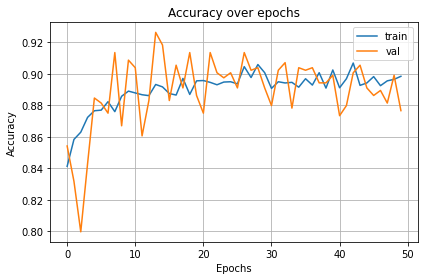

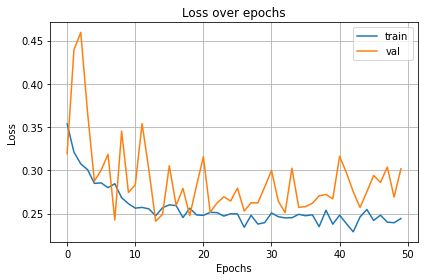

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Train set
========= Métricas do modelo ============

Loss is 0.0057 Accuracy is 4823/5216 92.47%

              precision    recall  f1-score   support

      normal      0.822     0.902     0.860      1341
   pneumonia      0.965     0.932     0.948      3875

    accuracy                          0.925      5216
   macro avg      0.894     0.917     0.904      5216
weighted avg      0.928     0.925     0.926      5216


========= Confusion Matrix ============



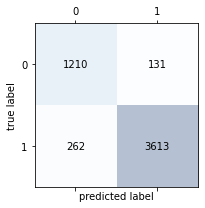

Test set
========= Métricas do modelo ============

Loss is 0.0077 Accuracy is 578/624 92.63%

              precision    recall  f1-score   support

      normal      0.948     0.850     0.896       234
   pneumonia      0.915     0.972     0.943       390

    accuracy                          0.926       624
   macro avg      0.932     0.911     0.920       624
weighted avg      0.928     0.926     0.925       624


========= Confusion Matrix ============



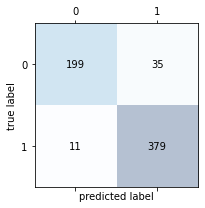

In [ ]:
googlenet, input_size = carregar_googlenet()
loaders = prepararDados(input_size)
print('Train set')
metricasModelo(model_ft, loaders['train'])
print('Test set')
metricasModelo(model_ft, loaders['test'])

# VGG

In [ ]:
model_name = 'vgg'

num_epochs = 50

model_ft = models.vgg19_bn(pretrained=True)
for param in model_ft.features.parameters():
  param.requires_grad = False
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
input_size = 224

loaders = prepararDados(input_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# lista dos parãmetros que serão aprendidos
params_to_update = model_ft.parameters()
print("Params to learn:")
if True:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Epoch 1/50
----------
train Loss: 0.5045 Acc: 0.7958
val Loss: 0.3394 Acc: 0.8365
Val acc up saving model
Duração: 318.8776149749756
Epoch 2/50
----------
train Loss: 0.3741 Acc: 0.8338
val Loss: 0.6558 Acc: 0.8061
Duração: 315.14072918891907
Epoch 3/50
----------
train Loss: 0.3585 Acc: 0.8510
val Loss: 0.3409 Acc: 0.8734
Val acc up saving model
Duração: 320.9974596500397
Epoch 4/50
----------
train Loss: 0.3171 Acc: 0.8600
val Loss: 0.3933 Acc: 0.8702
Duração: 320.80282616615295
Epoch 5/50
----------
train Loss: 0.2941 Acc: 0.8742
val Loss: 0.4488 Acc: 0.8702
Duração: 318.51562333106995
Epoch 6/50
----------
train Loss: 0.3026 Acc: 0.8781
val Loss: 0.3064 Acc: 0.8798
Val acc up saving model
Duração: 321.5401601791382
Epoch 7/50
----------
train Loss: 0.2771 Acc: 0.8808
val Loss: 0.4603 Acc: 0.8429
Duração: 319.62213230133057
Epoch 8/50
----------
train Loss: 0.2840 Acc: 0.8796
val Loss: 0.4446 Acc: 0.8510
Duração: 319.2988815307617
Epoch 9/50
----------
train Loss: 0.2802 Acc: 0.8819

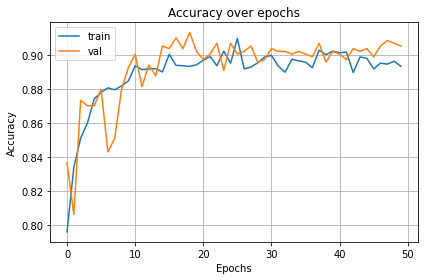

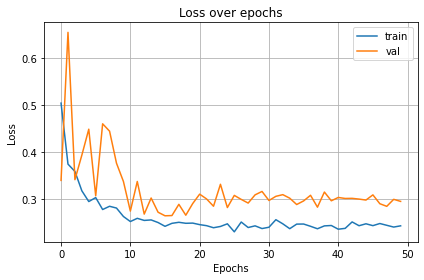

In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, loaders, criterion, optimizer_ft, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth



Test set
========= Métricas do modelo ============

Loss is 0.0084 Accuracy is 570/624 91.35%

              precision    recall  f1-score   support

      normal      0.959     0.803     0.874       234
   pneumonia      0.893     0.979     0.934       390

    accuracy                          0.913       624
   macro avg      0.926     0.891     0.904       624
weighted avg      0.918     0.913     0.912       624


========= Confusion Matrix ============



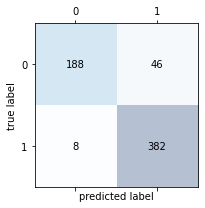

In [ ]:
vgg, input_size = carregar_vgg()
loaders = prepararDados(input_size)
print('Test set')
metricasModelo(vgg, loaders['test'])

# Agrupamento de redes

In [ ]:
#load the models
resnet, input_size = carregar_resnet()
vgg, input_size = carregar_vgg()
densenet, input_size = carregar_densenet()
alexnet, input_size = carregar_alexnet()
googlenet, input_size = carregar_googlenet()


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


VGG19 - Test set
========= Métricas do modelo ============

Loss is 0.0088 Accuracy is 570/624 91.35%

              precision    recall  f1-score   support

      normal      0.959     0.803     0.874       234
   pneumonia      0.893     0.979     0.934       390

    accuracy                          0.913       624
   macro avg      0.926     0.891     0.904       624
weighted avg      0.918     0.913     0.912       624


========= Confusion Matrix ============



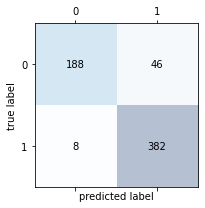

Resnet18 - Test set
========= Métricas do modelo ============

Loss is 0.0054 Accuracy is 589/624 94.39%

              precision    recall  f1-score   support

      normal      0.959     0.889     0.922       234
   pneumonia      0.936     0.977     0.956       390

    accuracy                          0.944       624
   macro avg      0.947     0.933     0.939       624
weighted avg      0.945     0.944     0.943       624


========= Confusion Matrix ============



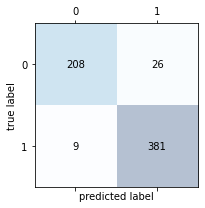

Densenet121 - Test set
========= Métricas do modelo ============

Loss is 0.0073 Accuracy is 581/624 93.11%

              precision    recall  f1-score   support

      normal      0.953     0.859     0.903       234
   pneumonia      0.920     0.974     0.946       390

    accuracy                          0.931       624
   macro avg      0.936     0.917     0.925       624
weighted avg      0.932     0.931     0.930       624


========= Confusion Matrix ============



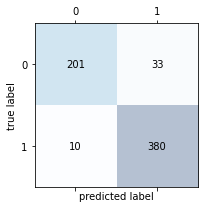

Alexnet - Test set
========= Métricas do modelo ============

Loss is 0.0084 Accuracy is 577/624 92.47%

              precision    recall  f1-score   support

      normal      0.923     0.872     0.897       234
   pneumonia      0.926     0.956     0.941       390

    accuracy                          0.925       624
   macro avg      0.924     0.914     0.919       624
weighted avg      0.925     0.925     0.924       624


========= Confusion Matrix ============



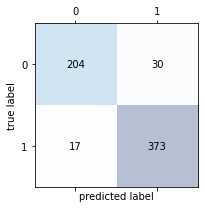

GoogleNet - Test set
========= Métricas do modelo ============

Loss is 0.0076 Accuracy is 578/624 92.63%

              precision    recall  f1-score   support

      normal      0.948     0.850     0.896       234
   pneumonia      0.915     0.972     0.943       390

    accuracy                          0.926       624
   macro avg      0.932     0.911     0.920       624
weighted avg      0.928     0.926     0.925       624


========= Confusion Matrix ============



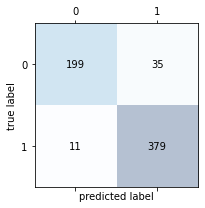

In [ ]:
#evaluate the models
loaders = prepararDados(input_size)

print('VGG19 - Test set')
metricasModelo(vgg, loaders['test'])

print('Resnet18 - Test set')
metricasModelo(resnet, loaders['test'])

print('Densenet121 - Test set')
metricasModelo(densenet, loaders['test'])

print('Alexnet - Test set')
metricasModelo(alexnet, loaders['test'])

print('GoogleNet - Test set')
metricasModelo(googlenet, loaders['test'])

========= Métricas do modelo ============

Accuracy is 590/624 94.55%

              precision    recall  f1-score   support

      normal      0.963     0.889     0.924       234
   pneumonia      0.936     0.979     0.957       390

    accuracy                          0.946       624
   macro avg      0.950     0.934     0.941       624
weighted avg      0.946     0.946     0.945       624


========= Confusion Matrix ============



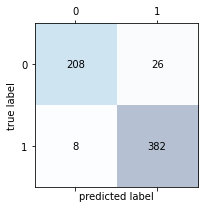

In [ ]:
# Usando predição por votação 

print('========= Métricas do modelo ============\n')
y_pred, y_test = testeAgrupamento(resnet, vgg, densenet, alexnet, googlenet, loaders['test'])
target_names = ['normal', 'pneumonia']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
print('\n========= Confusion Matrix ============\n')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

========= Métricas do modelo ============

Accuracy is 591/624 94.71%

              precision    recall  f1-score   support

      normal      0.976     0.880     0.926       234
   pneumonia      0.932     0.987     0.959       390

    accuracy                          0.947       624
   macro avg      0.954     0.934     0.942       624
weighted avg      0.949     0.947     0.947       624


========= Confusion Matrix ============



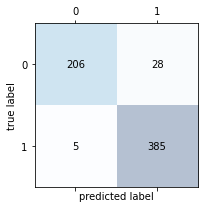

In [ ]:
# teste agrupamento usando média das logits

print('========= Métricas do modelo ============\n')
y_pred, y_test = testeAgrupamentoMediaLogits(resnet, vgg, densenet, alexnet, googlenet, loaders['test'])
target_names = ['normal', 'pneumonia']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
print('\n========= Confusion Matrix ============\n')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Acesso dados


In [ ]:
#preparação dos dados
loaders = prepararDados(224)
train_loader = loaders['train']
batch = next(iter(train_loader))
images, labels = batch

print(labels)

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1])


torch.Size([64, 3, 224, 224])
tensor([[[0.1686, 0.1843, 0.1804,  ..., 0.1569, 0.1569, 0.1608],
         [0.1647, 0.1843, 0.1804,  ..., 0.1569, 0.1608, 0.1647],
         [0.1647, 0.1843, 0.1765,  ..., 0.1529, 0.1647, 0.1686],
         ...,
         [0.1725, 0.1961, 0.2118,  ..., 0.0196, 0.0275, 0.0431],
         [0.1686, 0.1961, 0.2118,  ..., 0.0196, 0.0275, 0.0431],
         [0.1725, 0.1961, 0.2078,  ..., 0.0235, 0.0275, 0.0431]],

        [[0.1686, 0.1843, 0.1804,  ..., 0.1569, 0.1569, 0.1608],
         [0.1647, 0.1843, 0.1804,  ..., 0.1569, 0.1608, 0.1647],
         [0.1647, 0.1843, 0.1765,  ..., 0.1529, 0.1647, 0.1686],
         ...,
         [0.1725, 0.1961, 0.2118,  ..., 0.0196, 0.0275, 0.0431],
         [0.1686, 0.1961, 0.2118,  ..., 0.0196, 0.0275, 0.0431],
         [0.1725, 0.1961, 0.2078,  ..., 0.0235, 0.0275, 0.0431]],

        [[0.1686, 0.1843, 0.1804,  ..., 0.1569, 0.1569, 0.1608],
         [0.1647, 0.1843, 0.1804,  ..., 0.1569, 0.1608, 0.1647],
         [0.1647, 0.1843, 0.

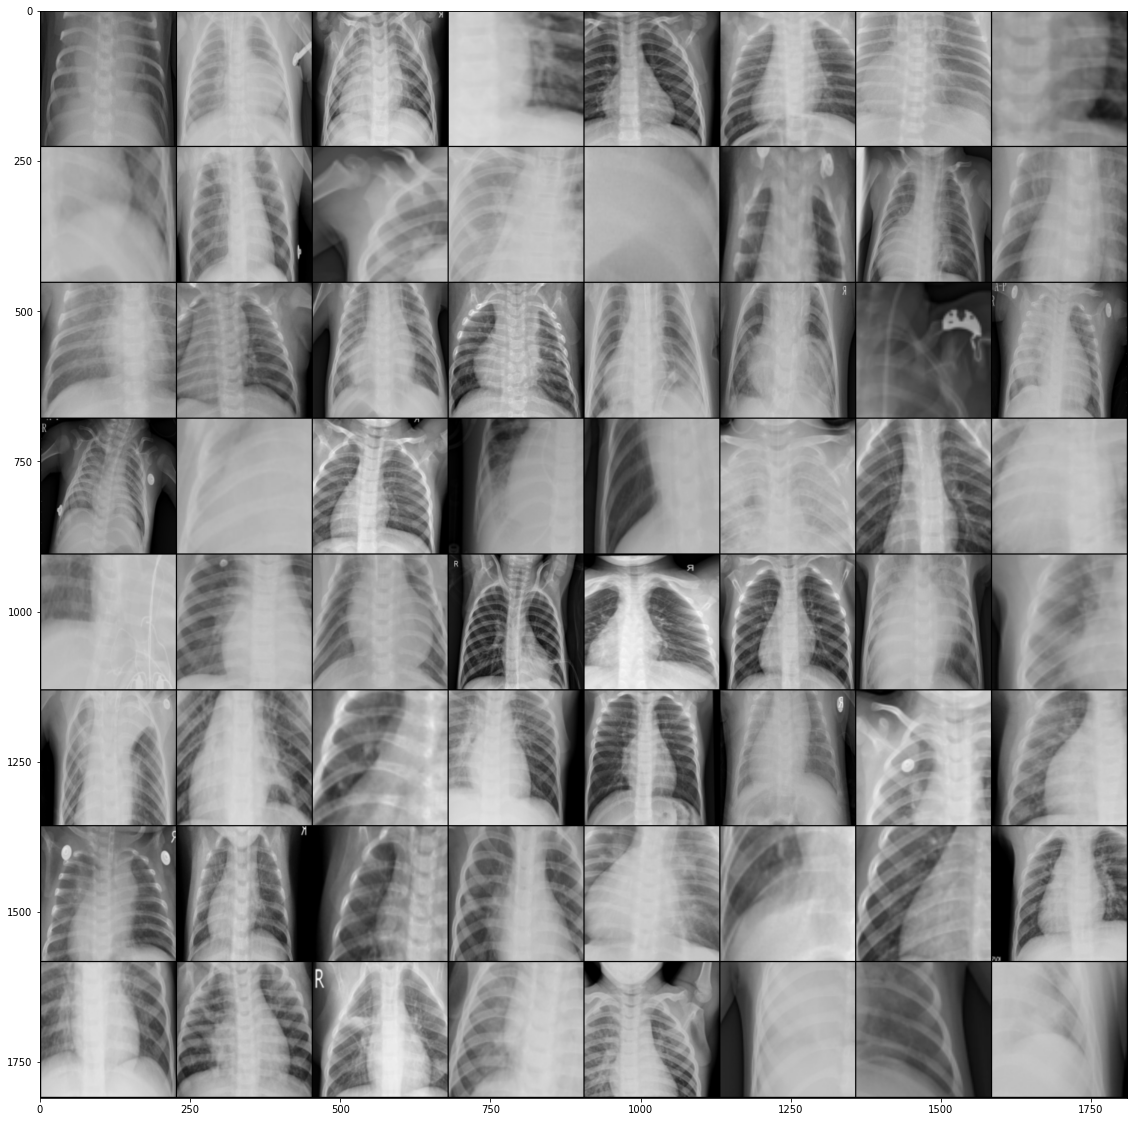

In [ ]:
# Acessando um batch de elementos do dataset
batch = next(iter(train_loader))
images, labels = batch
print(images.shape)
print(images[0])
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(grid, (1,2,0)))
print('Labels: ', labels)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
Labels:  tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1])


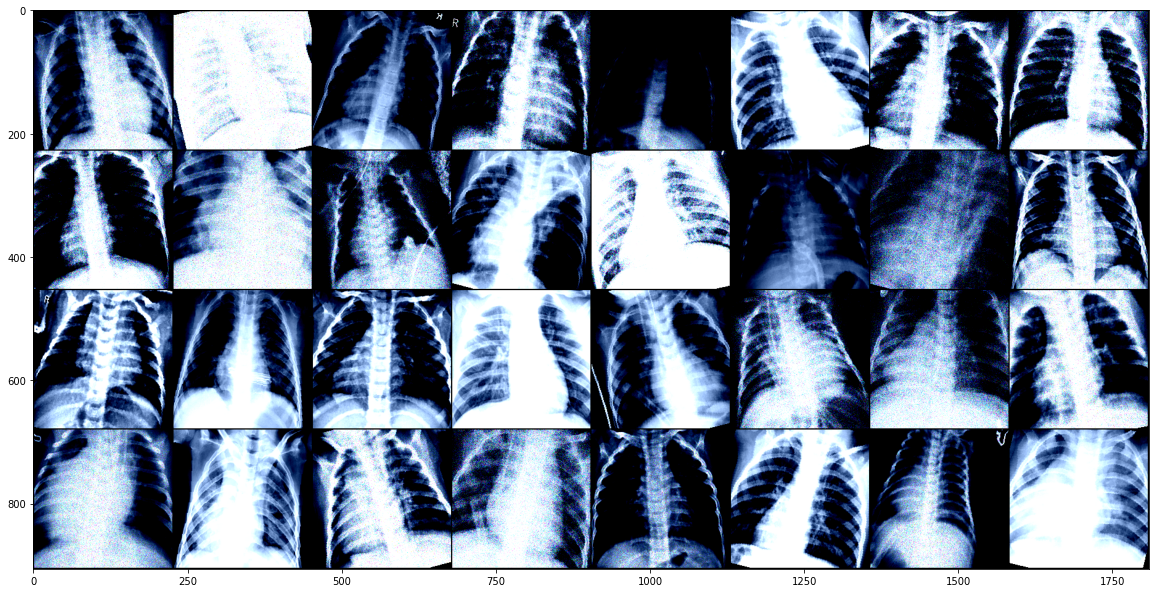

In [ ]:
# Acessando um batch de elementos do dataset
batch = next(iter(train_loader))
images, labels = batch

for i in range(len(images)): 
  noise = randint(0,2)
  if noise == 1:
    #aplica ruído gaussiano à imagem
    images[i] = torch.tensor(random_noise(images[i], mode='gaussian', mean=0, var=0.05, clip=True))
  if noise == 2:
    #aplica speckle noise à imagem
    images[i] = torch.tensor(random_noise(images[i], mode='speckle', mean=0, var=0.05, clip=True))


print(images.shape)
grid = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(grid, (1,2,0)))
print('Labels: ', labels)
plt.show()

# Modelo Estudante


In [ ]:
class Network(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super().__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
           
        )

        self.fc_layer = nn.Sequential(
           
            nn.Linear(14*14*24, 2),
       
         
        )

    def forward(self, x):  

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x



In [ ]:
model_name = 'aluno_2'

num_epochs = 25

aluno = Network()

loaders = prepararDados(224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

aluno = aluno.to(device)

# Observe that all parameters are being optimized
optimizer = optim.Adam(aluno.parameters(), lr=0.001, weight_decay=0.000125)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

print(aluno)

Network(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    

Epoch 1/25
----------
train Loss: 0.5165 Acc: 0.7676
val Loss: 0.6383 Acc: 0.6683
Val acc up saving model
Duração: 145.0963842868805
Epoch 2/25
----------
train Loss: 0.4375 Acc: 0.8127
val Loss: 0.4832 Acc: 0.7580
Val acc up saving model
Duração: 145.20401334762573
Epoch 3/25
----------
train Loss: 0.3766 Acc: 0.8391
val Loss: 0.4433 Acc: 0.8061
Val acc up saving model
Duração: 145.0080406665802
Epoch 4/25
----------
train Loss: 0.3472 Acc: 0.8576
val Loss: 0.4374 Acc: 0.8365
Val acc up saving model
Duração: 146.7405424118042
Epoch 5/25
----------
train Loss: 0.3311 Acc: 0.8593
val Loss: 0.4267 Acc: 0.8413
Val acc up saving model
Duração: 145.2243368625641
Epoch 6/25
----------
train Loss: 0.3217 Acc: 0.8668
val Loss: 0.5052 Acc: 0.8045
Duração: 144.82002186775208
Epoch 7/25
----------
train Loss: 0.2948 Acc: 0.8792
val Loss: 0.4986 Acc: 0.8205
Duração: 145.34560441970825
Epoch 8/25
----------
train Loss: 0.2985 Acc: 0.8817
val Loss: 0.3633 Acc: 0.8526
Val acc up saving model
Duração:

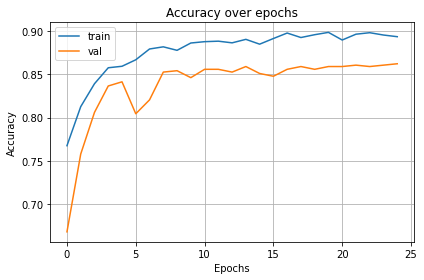

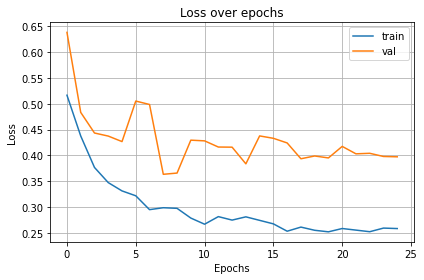

In [ ]:
# Train and evaluate
aluno, hist = train_model(aluno, loaders, criterion, optimizer, model_name, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Modelo estudante - Train set
========= Métricas do modelo ============

Loss is 0.0078 Accuracy is 4671/5216 89.55%

              precision    recall  f1-score   support

      normal      0.823     0.756     0.788      1341
   pneumonia      0.918     0.944     0.931      3875

    accuracy                          0.896      5216
   macro avg      0.870     0.850     0.859      5216
weighted avg      0.894     0.896     0.894      5216


========= Confusion Matrix ============



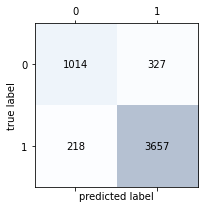

Modelo estudante - Test set
========= Métricas do modelo ============

Loss is 0.012 Accuracy is 538/624 86.22%

              precision    recall  f1-score   support

      normal      0.957     0.662     0.783       234
   pneumonia      0.829     0.982     0.899       390

    accuracy                          0.862       624
   macro avg      0.893     0.822     0.841       624
weighted avg      0.877     0.862     0.855       624


========= Confusion Matrix ============



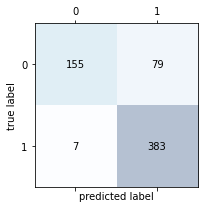

In [ ]:
aluno = carregar_cnn('/content/drive/My Drive/Modelos Salvos/Aluno/aluno_2.acc')
print('Modelo estudante - Train set')
metricasModelo(aluno, loaders['train'])
print('Modelo estudante - Test set')
metricasModelo(aluno, loaders['test'])

Epoch 1/25
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


train Loss: 0.2392 Acc: 0.8391
val Loss: 0.6472 Acc: 0.6859
Val acc up --> saving model
Duração: 215.08482933044434
Epoch 2/25
----------
train Loss: 0.1674 Acc: 0.8735
val Loss: 0.3200 Acc: 0.8606
Val acc up --> saving model
Duração: 215.17358946800232
Epoch 3/25
----------
train Loss: 0.1479 Acc: 0.8855
val Loss: 0.4528 Acc: 0.8333
Duração: 215.14628553390503
Epoch 4/25
----------
train Loss: 0.1178 Acc: 0.8926
val Loss: 0.4718 Acc: 0.8542
Duração: 215.81985187530518
Epoch 5/25
----------
train Loss: 0.1110 Acc: 0.8972
val Loss: 0.2883 Acc: 0.8862
Val acc up --> saving model
Duração: 215.74031472206116
Epoch 6/25
----------
train Loss: 0.0996 Acc: 0.9068
val Loss: 0.3669 Acc: 0.8702
Duração: 215.10855627059937
Epoch 7/25
----------
train Loss: 0.0858 Acc: 0.9147
val Loss: 0.3098 Acc: 0.8990
Val acc up --> saving model
Duração: 214.82101321220398
Epoch 8/25
----------
train Loss: 0.0835 Acc: 0.9214
val Loss: 0.3703 Acc: 0.8718
Duração: 214.8055329322815
Epoch 9/25
----------
train Los

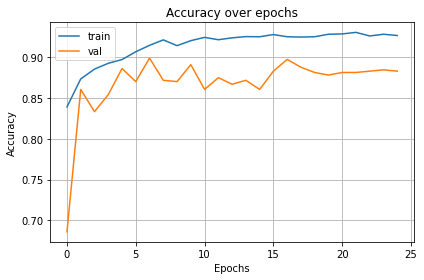

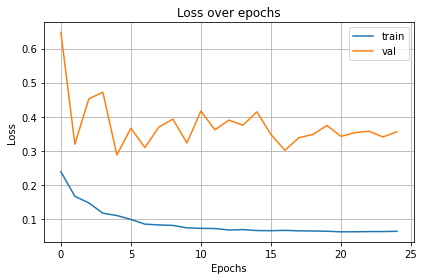

In [ ]:
model_name = 'aluno_kd_v2'

ensemble = carregar_ensemble()

num_epochs = 25

aluno = Network()

loaders = prepararDados(224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

aluno = aluno.to(device)

# Observe that all parameters are being optimized
optimizer = optim.Adam(aluno.parameters(), lr=0.001, weight_decay=0.000125)

T = 2
alpha = 0.9

# T=2 alpha = 0.9
aluno = train_model_kd_ensemble(aluno, ensemble, loaders, optimizer, model_name, T, alpha, num_epochs)

Modelo estudante - Train set
========= Métricas do modelo ============

Loss is 0.0068 Accuracy is 4724/5216 90.57%

              precision    recall  f1-score   support

      normal      0.832     0.793     0.812      1341
   pneumonia      0.929     0.945     0.937      3875

    accuracy                          0.906      5216
   macro avg      0.881     0.869     0.875      5216
weighted avg      0.904     0.906     0.905      5216


========= Confusion Matrix ============



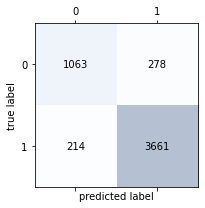

Modelo estudante - Test set
========= Métricas do modelo ============

Loss is  0.01 Accuracy is 561/624  89.9%

              precision    recall  f1-score   support

      normal      0.948     0.774     0.852       234
   pneumonia      0.878     0.974     0.923       390

    accuracy                          0.899       624
   macro avg      0.913     0.874     0.888       624
weighted avg      0.904     0.899     0.897       624


========= Confusion Matrix ============



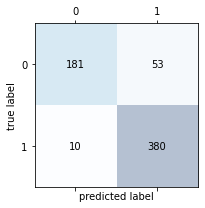

In [ ]:
print('Modelo estudante - Train set')
metricasModelo(aluno, loaders['train'])
print('Modelo estudante - Test set')
metricasModelo(aluno, loaders['test'])

# Treinamento KD


In [ ]:
def train_model_kd(model, teacher, dataloaders, optimizer, save_name, T, alpha, num_epochs=25):
  since = time.time()
  
  # informações para plotagem
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]

  # Gerencia a Learning Rate
  scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0  

  for epoch in range(1, num_epochs+1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    epochStart = time.time() 
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
            
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
      epoch_loss = 0.0
      epoch_acc = 0.0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:    
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):          
          outputs = model(inputs)          
          
          if phase == 'train':
            teacher_outputs = teacher(inputs)
            loss = loss_fn_kd(outputs, labels, teacher_outputs, T, alpha)
            loss.backward()
            optimizer.step()
          else: 
            loss = F.cross_entropy(outputs, labels)      
          
          _, preds = torch.max(outputs, 1)
         
          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)      
      
      if phase == 'train':
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc.item())         
      else:
        val_losses.append(epoch_loss)
        val_accuracy.append(epoch_acc.item())    

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))      

      # deep copy the model
      if phase == 'val' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        salvar_modelo(model, '/content/drive/My Drive/Modelos Salvos/'+save_name+'.acc')
        print('Val acc up --> saving model')
        
    scheduler.step()
    epochEnd = time.time()
    print('Duração:', (epochEnd - epochStart))
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  
  #plota os gráficos
  plotar(train_losses, train_accuracy, val_losses, val_accuracy)

  #salva dados da plotagem
  train = {'loss': train_losses, 'acc': train_accuracy}
  valid = {'loss': val_losses, 'acc': val_accuracy}

  df = pd.DataFrame(data=train)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_train.csv')

  df = pd.DataFrame(data=valid)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_valid.csv')
  
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

def loss_fn_kd(outputs, labels, teacher_outputs, T, alpha): 
  """ 
  Compute the knowledge-distillation (KD) loss given outputs, labels. 
  "Hyperparameters": temperature and alpha 

  NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher 
  and student expects the input tensor to be log probabilities! See Issue #2 
  """ 
  KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1), F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + F.cross_entropy(outputs, labels) * (1. - alpha)
  return KD_loss 

def train_model_kd_ensemble(model, ensemble, dataloaders, optimizer, save_name, T, alpha, num_epochs=25):
  since = time.time()

  if (torch.cuda.is_available()):
    resnet = ensemble['resnet']
    resnet = resnet.cuda()
    vgg = ensemble['vgg']
    vgg = vgg.cuda()
    densenet = ensemble['densenet']
    densenet = densenet.cuda()
    alexnet = ensemble['alexnet']
    alexnet = alexnet.cuda()
    googlenet = ensemble['googlenet']
    googlenet = googlenet.cuda()
  
  resnet.eval()
  densenet.eval()
  vgg.eval()
  alexnet.eval()
  googlenet.eval()

  
  # informações para plotagem
  train_losses , train_accuracy = [],[]
  val_losses , val_accuracy = [],[]

  # Gerencia a Learning Rate
  scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0  

  for epoch in range(1, num_epochs+1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    epochStart = time.time() 
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
            
      if phase == 'train':
          model.train()  # Set model to training mode
      else:
          model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
      epoch_loss = 0.0
      epoch_acc = 0.0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:    
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):          
          outputs = model(inputs)          
          
          if phase == 'train':
            output_resnet = resnet(inputs)
            output_densenet = densenet(inputs)
            output_alexnet = alexnet(inputs)
            output_googlenet = googlenet(inputs)
            output_vgg = vgg(inputs)

            teacher_outputs = (output_resnet+output_densenet+output_alexnet+output_googlenet+output_vgg)/5
            
            loss = loss_fn_kd(outputs, labels, teacher_outputs, T, alpha)
            loss.backward()
            optimizer.step()
          else: 
            loss = F.cross_entropy(outputs, labels)      
          
          _, preds = torch.max(outputs, 1)
         
          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)      
      
      if phase == 'train':
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc.item())         
      else:
        val_losses.append(epoch_loss)
        val_accuracy.append(epoch_acc.item())    

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))      

      # deep copy the model
      if phase == 'val' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        salvar_modelo(model, '/content/drive/My Drive/Modelos Salvos/'+save_name+'.acc')
        print('Val acc up --> saving model')
        
    scheduler.step()
    epochEnd = time.time()
    print('Duração:', (epochEnd - epochStart))
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  
  #plota os gráficos
  plotar(train_losses, train_accuracy, val_losses, val_accuracy)

  #salva dados da plotagem
  train = {'loss': train_losses, 'acc': train_accuracy}
  valid = {'loss': val_losses, 'acc': val_accuracy}

  df = pd.DataFrame(data=train)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_train.csv')

  df = pd.DataFrame(data=valid)
  df.to_csv('/content/drive/My Drive/Modelos Salvos/'+save_name+'_valid.csv')
  
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model


# Parâmetros



In [ ]:
def infoModelo(model):
  pytorch_total_params = sum(p.numel() for p in model.parameters())
  pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
 
  print('Parâmetros treináveis: ', pytorch_trainable_params)
  print('Parâmetros não treináveis: ', pytorch_total_params-pytorch_trainable_params)
  print('Total: ', pytorch_total_params)

In [ ]:
vgg = models.vgg19_bn(pretrained=True)
for param in vgg.features.parameters():
  param.requires_grad = False
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 2)
infoModelo(vgg)

Parâmetros treináveis:  119554050
Parâmetros não treináveis:  20035392
Total:  139589442


In [ ]:
resnet, input_size = initialize_model('resnet', 2, True, use_pretrained=True)
for param in resnet.layer4.parameters():
  param.requires_grad = True
infoModelo(resnet)

Parâmetros treináveis:  8394754
Parâmetros não treináveis:  2782784
Total:  11177538


In [ ]:
densenet, input_size = initialize_model('densenet', 2, True, use_pretrained=True)
for param in densenet.features.denseblock4.denselayer15.parameters():
  param.requires_grad = True

for param in densenet.features.denseblock4.denselayer16.parameters():
  param.requires_grad = True
infoModelo(densenet)

Parâmetros treináveis:  330050
Parâmetros não treináveis:  6625856
Total:  6955906


In [ ]:
model_ft, input_size = initialize_model('inception', 2, True, use_pretrained=True)
for param in model_ft.Mixed_7c.parameters():
  param.requires_grad = True
infoModelo(model_ft)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



Parâmetros treináveis:  6082436
Parâmetros não treináveis:  18266464
Total:  24348900


In [ ]:
model_ft, input_size = initialize_model('alexnet', 2,True , use_pretrained=True)
infoModelo(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Parâmetros treináveis:  54542338
Parâmetros não treináveis:  2469696
Total:  57012034


In [ ]:
model_ft = models.googlenet(pretrained=True)
set_parameter_requires_grad(model_ft, True)
for param in model_ft.inception5b.parameters():
  param.requires_grad = True
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
infoModelo(model_ft)

Parâmetros treináveis:  1349090
Parâmetros não treináveis:  4252864
Total:  5601954


In [ ]:
cnn = Network()
infoModelo(cnn)

Parâmetros treináveis:  30778
Parâmetros não treináveis:  0
Total:  30778


# Plotagens


Agrupamento de redes - Conjunto de treinamento

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/VGG/vgg_train.csv', header=None)
vgg_train_loss = df[1].iloc[0:][1:].astype('float')
vgg_train_acc = df[2].iloc[0:][1:].astype('float')

df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/Resnet18/resnet_train.csv', header=None)
resnet_train_loss = df[1].iloc[0:][1:].astype('float')
resnet_train_acc = df[2].iloc[0:][1:].astype('float')

df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/GoogLeNet/googlenet_train.csv', header=None)
googlenet_train_loss = df[1].iloc[0:][1:].astype('float')
googlenet_train_acc = df[2].iloc[0:][1:].astype('float')

df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/Densenet121/densenet_train.csv', header=None)
densenet_train_loss = df[1].iloc[0:][1:].astype('float')
densenet_train_acc = df[2].iloc[0:][1:].astype('float')

df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/AlexNet/alexnet_train.csv', header=None)
alexnet_train_loss = df[1].iloc[0:][1:].astype('float')
alexnet_train_acc = df[2].iloc[0:][1:].astype('float')

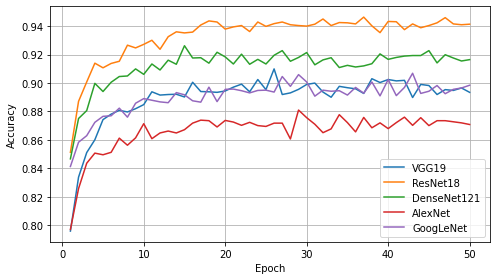

In [ ]:
# plotar tudo
mpl.rcParams['figure.figsize'] = (7, 4) #fig size
mpl.rcParams['axes.grid'] = False
vgg_train_acc.plot(label='VGG19')  
resnet_train_acc.plot(label='ResNet18')
densenet_train_acc.plot(label='DenseNet121')
alexnet_train_acc.plot(label='AlexNet')
googlenet_train_acc.plot(label='GoogLeNet')
# vgg_train_acc.plot(label='VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, which='both', axis='both')  
plt.tight_layout()
plt.legend()

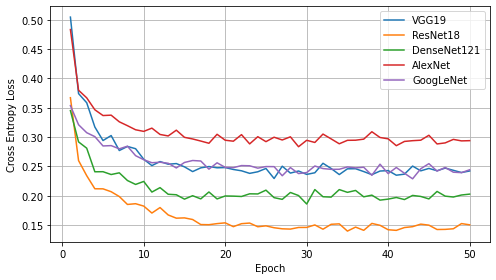

In [ ]:
# plotar tudo
mpl.rcParams['figure.figsize'] = (7, 4) #fig size
mpl.rcParams['axes.grid'] = False
vgg_train_loss.plot(label='VGG19')  
resnet_train_loss.plot(label='ResNet18')
densenet_train_loss.plot(label='DenseNet121')
alexnet_train_loss.plot(label='AlexNet')
googlenet_train_loss.plot(label='GoogLeNet')
# vgg_train_acc.plot(label='VGG19')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True, which='both', axis='both')  
plt.tight_layout()
plt.legend()

Modelo Estudante

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/Aluno/aluno_2_train.csv', header=None)
aluno_train_loss = df[1].iloc[0:][1:].astype('float')
aluno_train_acc = df[2].iloc[0:][1:].astype('float')

df = pd.read_csv('/content/drive/My Drive/Modelos Salvos/Aluno/aluno_kd_v2_train.csv', header=None)
aluno_kd_train_loss = df[1].iloc[0:][1:].astype('float')
aluno_kd_train_acc = df[2].iloc[0:][1:].astype('float')

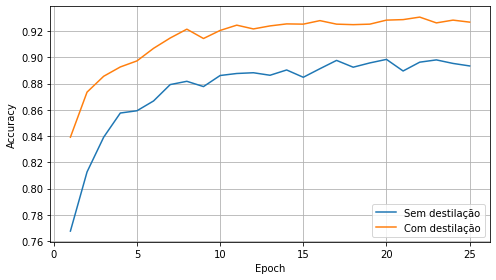

In [ ]:
# plotar tudo
mpl.rcParams['figure.figsize'] = (7, 4) #fig size
mpl.rcParams['axes.grid'] = False
aluno_train_acc.plot(label='Sem destilação')  
aluno_kd_train_acc.plot(label='Com destilação')
# vgg_train_acc.plot(label='VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, which='both', axis='both')  
plt.tight_layout()
plt.legend()

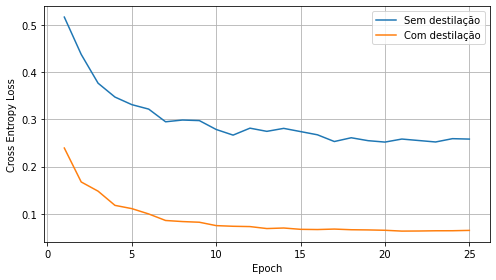

In [ ]:
# plotar tudo
mpl.rcParams['figure.figsize'] = (7, 4) #fig size
mpl.rcParams['axes.grid'] = False
aluno_train_loss.plot(label='Sem destilação')  
aluno_kd_train_loss.plot(label='Com destilação')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True, which='both', axis='both')  
plt.tight_layout()
plt.legend()